# Redes Generativas Antagonicas - GAN

### Requisitos: pip install tensorflow numpy matplotlib

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# cargar el dataset MNIST
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255.0  # normalizar imágenes entre 0 y 1
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')  # cambiar la forma a (num_samples, 28, 28, 1)

In [3]:
# tamaño del espacio latente (ruido de entrada para el generador)
latent_dim = 100

In [4]:
# crear el generador
def build_generator():
    model = Sequential(
        [
            Dense(256, input_dim=latent_dim),
            LeakyReLU(alpha=0.2),
            BatchNormalization(),
            Dense(512),
            LeakyReLU(alpha=0.2),
            BatchNormalization(),
            Dense(1024),
            LeakyReLU(alpha=0.2),
            BatchNormalization(),
            Dense(28 * 28 * 1, activation="tanh"),
            Reshape((28, 28, 1)),
        ]
    )
    return model

In [5]:
# crear el discriminador
def build_discriminador():
    model = Sequential(
        [
            Flatten(input_shape=(28, 28, 1)),
            Dense(512),
            LeakyReLU(alpha=0.2),
            Dense(1, activation="sigmoid"),  # clasificacion entre real 1 y falso 0
        ]
    )
    return model

In [6]:
# compilar el model
discriminador = build_discriminador()
discriminador.compile(
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

c:\Users\Sjvn\Desktop\Personal\URL\Inteligencia Artificial\Jupyter-clases\entornoJupyter\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Sjvn\Desktop\Personal\URL\Inteligencia Artificial\Jupyter-clases\entornoJupyter\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [7]:
# compilar el generador (dentro de GAN)
generador = build_generator()

c:\Users\Sjvn\Desktop\Personal\URL\Inteligencia Artificial\Jupyter-clases\entornoJupyter\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# congelar el discriminador durante el entrenamiento del generador
discriminador.trainable = False

# crear la GAN combinando el generador y el discriminador
gan_input = tf.keras.Input(shape=(latent_dim,))
gan_output = discriminador(generador(gan_input))
gan = tf.keras.Model(gan_input, gan_output)

In [9]:
# compilar la GAN
gan.compile(
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    loss="binary_crossentropy",
)

In [10]:
def generate_and_save_images(
    epoch, generator, ejemplos=16, dim=(4, 4), figsize=(10, 10)
):
    noise = np.random.normal(0, 1, size=(ejemplos, latent_dim))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(ejemplos, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        # crear una subgráfica para cada imagen generada
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i], interpolation="nearest", cmap="gray_r")
        plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"gan_generated_epoch_{epoch}.png")
    plt.show()


In [11]:
def train_gan(epochs=10000, batch_size=128):
    batch_count = x_train.shape[0] // batch_size

    for epoch in range(epochs):
        for _ in range(batch_count):
            noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
            generated_images = generador.predict(noise)
            real_images = x_train[
                np.random.randint(0, x_train.shape[0], size=batch_size)
            ]

            X = np.concatenate([real_images, generated_images])
            Y = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])

            d_loss = discriminador.train_on_batch(X, Y)
            g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        if epoch % 1000 == 0:
            d_loss_val = d_loss[0] if isinstance(d_loss, (list, tuple)) else d_loss
            g_loss_val = g_loss[0] if isinstance(g_loss, (list, tuple)) else g_loss

            print(
                f"Epoch {epoch} | Discriminator Loss: {d_loss_val} | Generator Loss: {g_loss_val}"
            )

            generate_and_save_images(epoch, generador)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 


c:\Users\Sjvn\Desktop\Personal\URL\Inteligencia Artificial\Jupyter-clases\entornoJupyter\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━

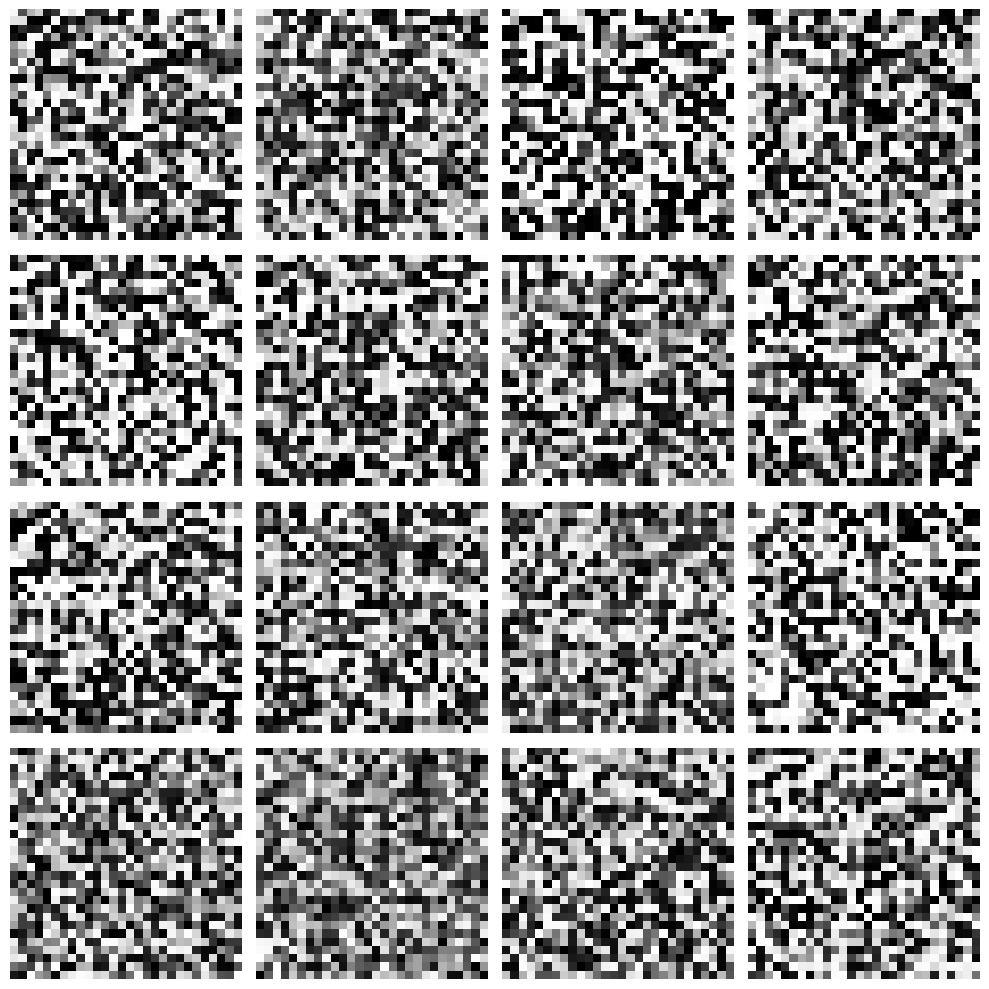

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━

In [ ]:
train_gan(epochs=10000, batch_size=128)